In [1]:
import pygsp as p

import numpy as np
from numpy.linalg import matrix_rank, inv, pinv
import matplotlib.pyplot as plt

import cv2

from scipy import fft

from scipy.sparse.linalg import eigs
from scipy.linalg import eig
from scipy.optimize import linprog, minimize, Bounds

import pandas as pd

from math import cos, asin, sqrt, pi

from spielman_learning import *

In [2]:
# from ripser import ripser
# from persim import plot_diagrams

In [3]:
data = pd.read_csv('data/weather/weatherAUS.csv')

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
places_to_remove = ['MountGinini', 'SydneyAirport', 'MelbourneAirport',
                    'PearceRAAF', 'PerthAirport', 'MountGambier', 'NorfolkIsland', ]
data = data[~data['Location'].isin(places_to_remove)]

In [5]:
num_locations = 49 - len(places_to_remove)

In [6]:
geo_locations = dict({ #decimal degrees
                    'Albury': (-36.080477, 146.916280),
                    'BadgerysCreek': (-33.881667, 150.744163),
                    'Cobar': (-31.498333, 145.834444),
                    'CoffsHarbour': (-30.296241, 153.113529),
                    'Moree': (-29.461720, 149.840715),
                    'Newcastle': (-32.919295, 151.779535),
                    'NorahHead': (-33.281667, 151.567778),
                    'NorfolkIsland': (-29.028958, 167.958729),
                    'Penrith': (-33.751079, 150.694168),
                    'Richmond': (-37.820395, 145.002515),
                    'Sydney': (-33.869844, 151.208285),
                    'SydneyAirport': (-33.935309, 151.165582),
                    'WaggaWagga': (-35.115000, 147.367778),
                    'Williamtown': (-32.815000, 151.842778),
                    'Wollongong': (-34.424394, 150.893850),
                    'Canberra': (-35.297591, 149.101268),
                    'Tuggeranong': (-35.420977, 149.092134),
                    'MountGinini': (-35.529744, 148.772540),
                    'Ballarat': (-37.562303, 143.860565),
                    'Bendigo': (-36.758877, 144.282593),
                    'Sale': (-38.105036, 147.064790),
                    'MelbourneAirport': (-37.666951, 144.833493),
                    'Melbourne': (-37.814218, 144.963161),
                    'Mildura': (-34.184726, 142.162497),
                    'Nhil': (-36.333130, 141.649293),
                    'Portland': (-38.345623, 141.604230),
                    'Watsonia': (-37.711002, 145.083635),
                    'Dartmoor': (-27.996162, 115.189218),
                    'Brisbane': (-27.468968, 153.023499),
                    'Cairns': (-16.920666, 145.772185),
                    'GoldCoast': (-28.002373, 153.414599),
                    'Townsville': (-19.256939, 146.823954),
                    'Adelaide': (-34.928181, 138.599931),
                    'MountGambier': (-37.824670, 140.782007),
                    'Nuriootpa': (-34.469335, 138.993901),
                    'Woomera': (-31.199914, 136.825353),
                    'Albany': (-35.024782, 117.883608),
                    'Witchcliffe': (-34.010273, 115.115673),
                    'PearceRAAF': (-31.673960, 116.017544),
                    'PerthAirport': (-31.940610, 115.967608),
                    'Perth': (-31.955896, 115.860580),
                    'SalmonGums': (-32.981535, 121.643942),
                    'Walpole': (-34.977680, 116.731006),
                    'Hobart': (-42.882509, 147.328123),
                    'Launceston': (-41.434081, 147.137350),
                    'AliceSprings': (-23.698388, 133.881289),
                    'Darwin': (-12.460440, 130.841047),
                    'Katherine': (-14.464616, 132.263599),
                    'Uluru': (-25.345554, 131.036961)
                     })

In [7]:
for place in places_to_remove:
    geo_locations.pop(place)

In [8]:
cols = ['Temp3pm', 'Humidity3pm', 'Rainfall']
data_geos = {c: data.dropna(subset = [c])[['Date', 'Location', *cols]] for c in cols}

In [9]:
dates = {c: np.unique(data_geos[c]['Date'].values) for c in cols}

In [10]:
%%time
full_dates = {c: [d for d in dates[c] if len(data_geos[c][data_geos[c]['Date'] == d]) == num_locations] for c in cols}

CPU times: user 1min 41s, sys: 46.9 ms, total: 1min 41s
Wall time: 1min 42s


In [11]:
#number of dates where the complete signal is available
len(full_dates[cols[0]]), len(full_dates[cols[1]]), len(full_dates[cols[2]])

(530, 411, 499)

In [12]:
summer_days = [d for d in full_dates[cols[0]] if d[5:7] in ['12', '01', '02']]
autumn_days = [d for d in full_dates[cols[0]] if d[5:7] in ['03', '04', '05']]
winter_days = [d for d in full_dates[cols[0]] if d[5:7] in ['06', '07', '08']]
spring_days = [d for d in full_dates[cols[0]] if d[5:7] in ['09', '10', '11']]
len(summer_days), len(autumn_days), len(winter_days), len(spring_days) 

(85, 127, 151, 167)

In [13]:
k = 8 #number of observations
rs = np.random.RandomState(12345)
random_indexes = {c: rs.randint(len(full_dates[c]), size = (k, 1)) for c in cols}
# random_dates = {c: np.array(full_dates[c])[random_indexes[c]].flatten() for c in cols} 
random_dates = {c: np.array([summer_days[0], summer_days[-1], 
                autumn_days[0], autumn_days[-1],
                winter_days[0], winter_days[-1],
                spring_days[0], spring_days[-1]]) for c in cols}

In [14]:
print(cols[0], ': ', random_dates[cols[0]],'\n' + cols[1] + ': ', random_dates[cols[1]], '\n' + cols[2] + ': ', random_dates[cols[2]]) 

Temp3pm :  ['2013-12-01' '2015-01-05' '2013-03-01' '2014-05-31' '2013-06-02'
 '2014-08-31' '2013-09-01' '2014-11-30'] 
Humidity3pm:  ['2013-12-01' '2015-01-05' '2013-03-01' '2014-05-31' '2013-06-02'
 '2014-08-31' '2013-09-01' '2014-11-30'] 
Rainfall:  ['2013-12-01' '2015-01-05' '2013-03-01' '2014-05-31' '2013-06-02'
 '2014-08-31' '2013-09-01' '2014-11-30']


In [15]:
def get_index(place):
    return list(vertice_labels.values()).index(place)

vertice_labels = {i: data_geos[cols[0]][data_geos[cols[0]]['Date'] == full_dates[cols[0]][0]]['Location'].values[i] for i in range(num_locations)}  
signals = {c: np.array([data_geos[c][data_geos[c]['Date'] == d][c].values for d in random_dates[c]], dtype=object) for c in cols}

In [16]:
x1 = signals[cols[0]].T
x2 = signals[cols[1]].T
n, d = np.shape(x1)

# L0 = np.arange(0, n ** 2, 1).reshape((n, n))/100
L0 = np.ones((n, n))
ws = L0[np.triu_indices(np.shape(x1)[0], k = 1)]

g = lambda ws: objective_function_spielman(x1, ws, True)
# h = lambda ws: objective_function_spielman(x2, ws);

In [17]:
def check_constraint(n, ws, α):
    _, ds = vector_to_matrix(n, ws)
    print(α * n - sum([max(0, 1 - di) for di in ds]), 'αn - sum')

In [18]:
def objective_function_spielman(x, ws, verbose):
    
    n, d = np.shape(x)
    W, ds = vector_to_matrix(np.shape(x)[0], ws)
    L = np.diag(ds) - W
    if verbose:
        print(check_constraint(n, ws, α = α))
    return np.linalg.norm(L @ x)

In [19]:
%%time
α = 0.3
t = 2
res_temp = minimize(g, ws, bounds = bounds_spielman(len(ws)), constraints = constraints_spielman(n, ws, α, True), 
               tol = 1 * 10 ** (-t), method = 'trust-constr')
# res_hum = minimize(h, ws, bounds = bounds_spielman(len(ws)), constraints = constraints_spielman(n, ws, α), 
#                tol = 1 * 10 ** (-t))

res_temp.success #deu certo?

12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - su

12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - su

12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - su

12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - su

/home/thiago/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - su

12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - su

-52.10698154246908 αn - sum
None
-52.10698154246908 αn - sum
None
-52.1069815722714 αn - sum
None
-52.10698154246908 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.1069815

None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.1069815722714 αn - sum
None
-52.1069815722714 αn - sum
None
-52.106981575254714 αn - sum
None
-52.1069815722714 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.106

-52.10698154246908 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.1069815722714 αn - sum
None
-52.1069815722714 αn - sum
None
-52.10698158083772 αn - sum
None
-52.10698157612138 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.1069815722714 αn - sum
None
-52.1069815722714 αn - sum
None
-52.1069815788785 αn - sum
None
-52.1069815722714 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.1069815722714 αn - sum
None
-52.1069815722714 αn - sum
None
-52.10698157249326 αn - sum
None
-52.1069815722714 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 αn - sum
None
-52.10698155737024 

6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931524856722 αn - sum
None
6.533931524856722 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931

6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931524856722 αn - sum
None
6.533931524856722 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931

6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931554659044 αn - sum
None
6.53393155514022 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931524856722 αn - sum
None
6.533931524856722 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.533931539757883 αn - sum
None
6.5339315

12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - su

12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - su

12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - su

12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - su

12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - su

12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - su

12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - sum
None
12.6 αn - su

12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067222889628 αn - sum
None
12.54067221399512 αn - sum
None
12.54067

12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067222889628 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067

12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067222889628 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067222889628 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067222889628 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067221399512 αn - sum
None
12.54067

12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414357414729 αn - sum
None
12.531414357414729 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.5314143

12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414357414729 αn - sum
None
12.531414357414729 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.5314143

12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414357414729 αn - sum
None
12.531414357414729 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414357414729 αn - sum
None
12.531414357414729 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.531414342513568 αn - sum
None
12.5314143

12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097153467574 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097

12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097153467574 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097

12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.220971549576902 αn - sum
None
12.220971549576902 αn - sum
None
12.220971549576902 αn - sum
None
12.220971549576902 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097151977458 αn - sum
None
12.22097151977458 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097151977458 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.22097153467574 αn - sum
None
12.2

11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.9721747608744 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.9721747608744 αn - sum
None
11.9721747608744 αn - sum
None
11.9721747608744 αn - sum
None
11.9721747608744 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.9721747459

11.9721747608744 αn - sum
None
11.9721747608744 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.9721747608744 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.9721747608744 αn - sum
None
11.9721747608744 αn - sum
None
11.9721747608744 αn - sum
None
11.9721747608744 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.97217474597324 αn - sum
None
11.972174745973

-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814177931327 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.5158141

-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814177931327 αn - sum
None
-5.515814177931327 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.5158141

-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.515814163030166 αn - sum
None
-5.5158141

-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.002864

-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.002864

-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.00286464259692 αn - sum
None
-12.002864

-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.7259988002

-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.7259988002

-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.725998800233144 αn - sum
None
-12.7259988002

-13.33949833229711 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.33949830249

-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.3394983024

-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.3394983024

-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.339498302494787 αn - sum
None
-13.3394983024

-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.6743825518

-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.6743825518

-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.674382551864321 αn - sum
None
-13.6743825518

True

In [20]:
L_temp = make_graph(np.shape(x1)[0], res_temp.x, tol = 1e-2)
# L_hum = make_graph(np.shape(x1)[0], res_hum.x, tol = t)
L_temp.set_coordinates([[geo_locations[vertice_labels[i]][1],
                         geo_locations[vertice_labels[i]][0]] for i in range(num_locations)])
# L_hum.set_coordinates([[geo_locations[vertice_labels[i]][1], geo_locations[vertice_labels[i]][0]] for i in range(49)])

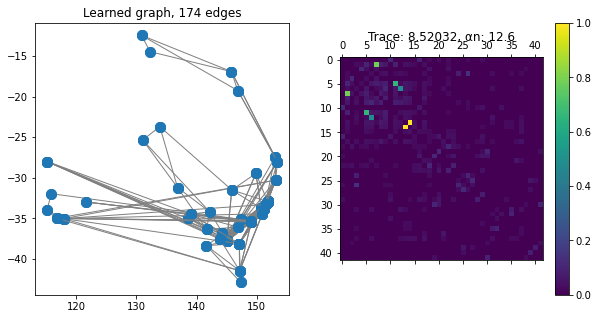

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

L_temp.plot(ax = ax[0])
ax[1].matshow(L_temp.W.todense())
ax[0].set_title('Learned graph, ' + str(L_temp.Ne) + ' edges')
ax[1].set_title('Trace: ' + str(np.round(np.trace(L_temp.L.todense()), 5)) + ', αn: ' + str(α * n))
sm = plt.cm.ScalarMappable()
sm.set_array([])
  
plt.colorbar(sm, ax = ax[1])
plt.show()
# L_temp.plot(ax = ax[1])

In [22]:
L_temp.compute_fourier_basis()
# L_hum.compute_fourier_basis()

In [23]:
ns = [list(place) for place in np.array(np.nonzero(L_temp.W.todense() > 0)).T]

In [24]:
neighbors = dict()
for place in ns:
    i, j = place
    if(vertice_labels[i] in neighbors.keys()):
        neighbors[vertice_labels[i]].append(vertice_labels[j])
    else:
        neighbors[vertice_labels[i]] = [vertice_labels[j]]

has_neighbors = []
for pl in neighbors.keys():
    has_neighbors += [get_index(pl)]
no_neighbors = [i for i in range(num_locations) if i not in has_neighbors]

In [25]:
L_temp.is_connected(), no_neighbors #isolated vertices

(True, [])

In [26]:
distance_weight_ratio = {}
max_ws_ds = {}
for place1 in neighbors.keys():
    i = get_index(place1)
    md, mw = 0, 0
    for place2 in neighbors[place1]:
        j = get_index(place2)
        dist = great_circle_distance(*geo_locations[place1], *geo_locations[place2])
        w = L_temp.W[i, j]
        if place1 not in distance_weight_ratio.keys():
            distance_weight_ratio[place1] = [dist * w]
        else:
            distance_weight_ratio[place1].append(dist * w)            
        if dist > md:
            md = dist
        if w > mw:
            mw = w
    max_ws_ds[place1] = (md, mw)

In [27]:
place_ticks = []
for place in max_ws_ds.keys():
    if max_ws_ds[place][0] * max_ws_ds[place][1] >= 0.07:
        place_ticks += [(get_index(place), place)]

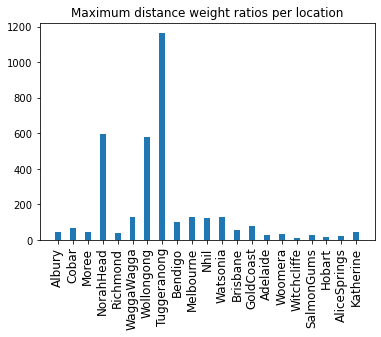

In [28]:
skip = 2
plt.bar(np.arange(num_locations)[::skip], [max_ws_ds[place][0] * max_ws_ds[place][1] for place in max_ws_ds.keys()][::skip])
plt.xticks([p[0] for p in place_ticks][::skip], [p[1] for p in place_ticks][::skip], rotation = 90, fontsize=12)
plt.title('Maximum distance weight ratios per location')
plt.show()

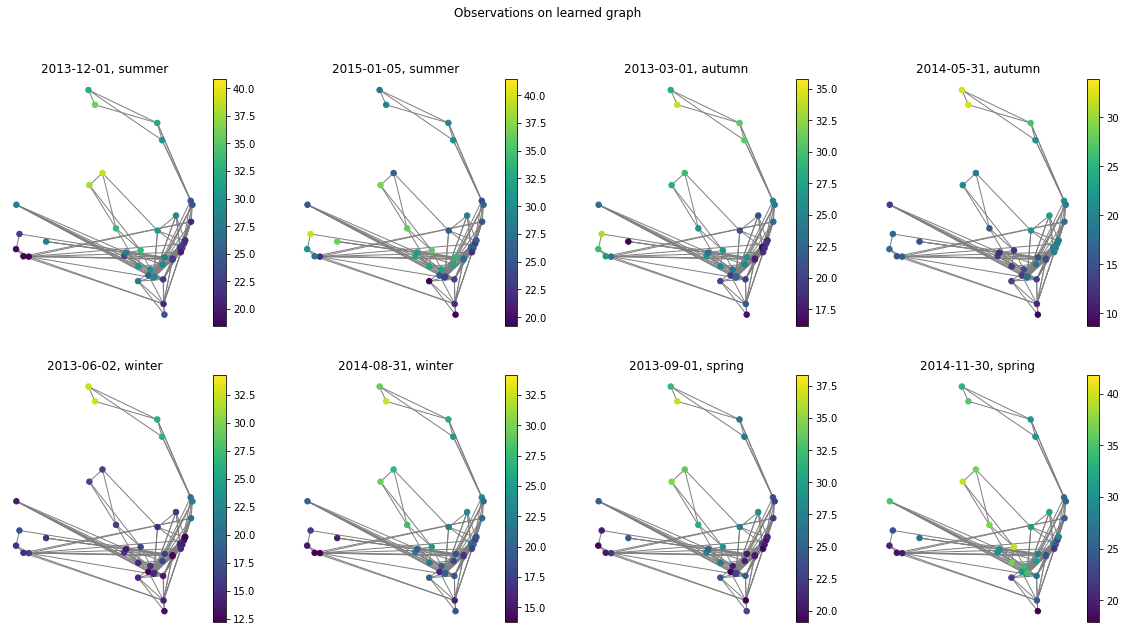

In [29]:
fig, ax = plt.subplots(2, k // 2, figsize = (20, 10))

titles = 2 * ['summer'] + 2 * ['autumn'] + 2 * ['winter'] + 2 * ['spring']
for i in range(2):
    for j in range(k // 2):
        L_temp.plot_signal(x1.T[i * (k // 2) + j], ax=ax[i][j], vertex_size = 30)
#         ax[i][j].set_title(random_dates[cols[0]][i * (k // 2) + j])
        ax[i][j].axis('off')
        ax[i][j].set_title(random_dates[cols[0]][i * (k // 2) + j] + ', ' + titles[i * (k // 2) + j])
# for j, i in enumerate([0,5,8]):
#     L_temp.plot_signal(x1.T[i], ax=ax[0][j], vertex_size = 30)
#     ax[1][j].stem(np.abs(L_temp.gft(x1.T[i])))
#     ax[0][j].axis('off')
# #     ax[1][i].axis('off')
#     ax[0][j].set_title(random_dates[cols[0]][i])
#     ax[1][j].set_title('Quadratic laplacian form of x: ' + str(np.round(x1[:, i] @ (L_temp.L) @ x1[:, i], 5)))

# ax[1][0].set_ylabel('Magnitude of coefficients in the GFT')    
plt.suptitle('Observations on learned graph')
plt.show()

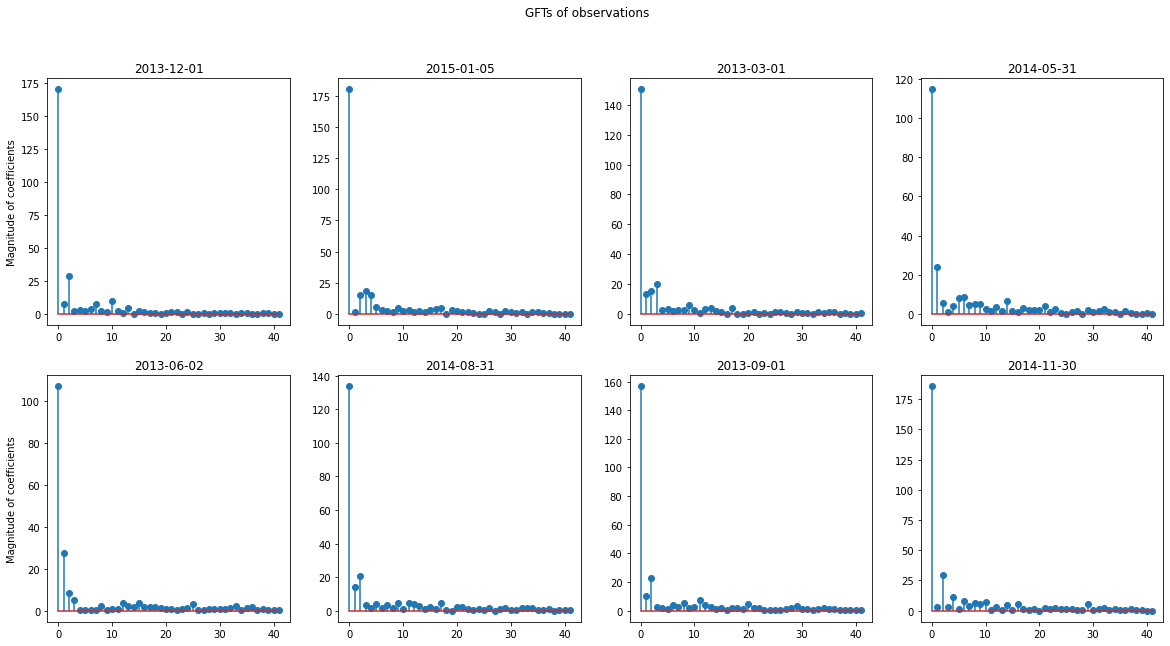

In [30]:
fig, ax = plt.subplots(2, k // 2, figsize = (20, 10))

for i in range(2):
    ax[i][0].set_ylabel('Magnitude of coefficients')
    for j in range(k // 2):
        ax[i][j].stem(np.abs(L_temp.gft(x1.T[i * (k // 2) + j])), use_line_collection = True)
        ax[i][j].set_title(random_dates[cols[0]][i * (k // 2) + j])
        
fig.suptitle('GFTs of observations')
plt.show()

In [31]:
normalize = np.sqrt(np.diag(1 / np.diagonal(L_temp.L.todense())))
L_temp.L_normalized = normalize @ L_temp.L @ normalize

In [32]:
for i in range(k):
    print((np.linalg.norm(x1[:, i])))

173.5296228313771
182.816383292089
153.4449412655888
118.7093930571629
111.27263814613187
136.8681482303315
159.53237915858963
189.57246635521733


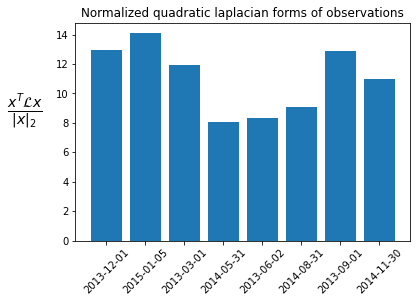

In [33]:
plt.bar(np.arange(k), [(x1[:, i] @ (L_temp.L_normalized) @ x1[:, i]) / (np.linalg.norm(x1[:, i])) for i in range(k)])
plt.xticks(np.arange(k),random_dates[cols[0]], rotation = 45)
plt.title('Normalized quadratic laplacian forms of observations')
plt.ylabel(r'$\frac{x^T \mathcal{L} x}{\| x \|_2}$         ', fontsize = 20, rotation = 0)
plt.show()

In [34]:
# date = '2015-10-15'
# missing_temperatures = {'Newcastle': 26.1, 'Melbourne': 34, 'Albany': 14, 'Katherine': 36.5} 
# #Melbourne entre 29-34, Albany entre 14 e 17 e Katherine entre 35 e 38